In [54]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))



# Create the dataset

In [55]:
from typing import Tuple
import numpy as np

def two_sins_series(
    n_points: int = 70,
    x_start: float = 0.0,
    x_end: float = 1.0,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generates the '2 sins' synthetic series and normalizes to [0, 1].

    f(x) = \frac{sin(5.0x)+0.5sin(8.0x)}{4} + 0.5   
    as per the description in the paper:"""
    x = np.linspace(x_start, x_end, n_points, dtype=float)
    y = ((np.sin(5.0 * x) + 0.5 * np.sin(8.0 * x)) / 4.0) + 0.5

    # normalize to [0, 1] (paper says "(0–1)"; min-max gives [0,1])
    y_min, y_max = float(y.min()), float(y.max())
    if np.isclose(y_max, y_min):
        raise ValueError("Degenerate series: cannot normalize (max == min).")
    y_norm = (y - y_min) / (y_max - y_min)

    return x, y_norm

In [56]:
def paa(y, w):
    if isinstance(y, tuple):
        y = y[1]  # assume (x, y)

    y = np.asarray(y)
    n = len(y)

    return np.array([
        y[int(i*n/w):int((i+1)*n/w)].mean()
        for i in range(w)
    ])


Generated '2 sins' series with 70 points.


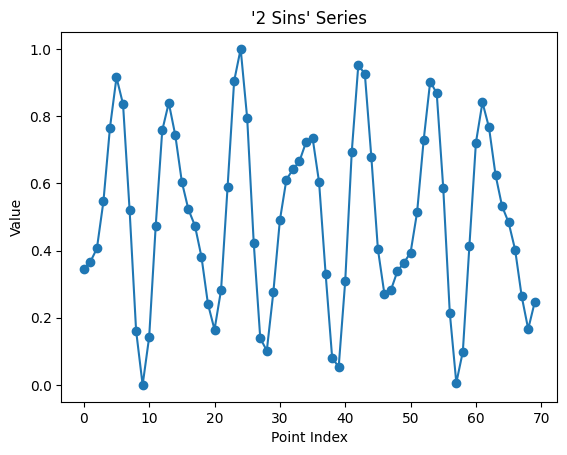

In [57]:

dataset = two_sins_series(n_points=70, x_start=1.0, x_end=10.0)
x, y = dataset
n_points = len(x)
print(f"Generated '2 sins' series with {n_points} points.")
# Visualize the series with x axis showing number of points. 'o' markers for points.
import matplotlib.pyplot as plt
plt.plot(range(n_points), y, marker='o')
plt.title("'2 Sins' Series")
plt.xlabel("Point Index")
plt.ylabel("Value")
plt.show()

# Create PAA encoded versions of the 2sin dataset

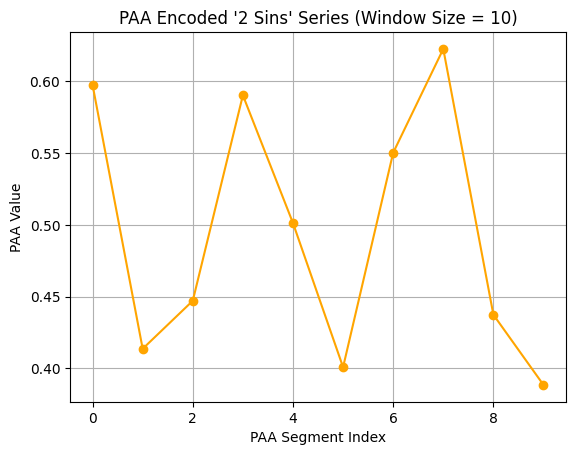

In [58]:

x, y = dataset
# Apply PAA encoding with window size 10
encoded_series = paa(y, w=10)
# Visualize the encoded series
plt.plot(encoded_series, marker="o", color="orange")
plt.title("PAA Encoded '2 Sins' Series (Window Size = 10)")
plt.xlabel("PAA Segment Index")
plt.ylabel("PAA Value")
plt.grid()
plt.show()

In [59]:
from qiskit.primitives import Sampler, Estimator

seed = 2022
shots = 10000

sampler = Sampler()
estimator = Estimator()

C:\Users\benja\AppData\Local\Temp\ipykernel_13152\3259191324.py:6: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\benja\AppData\Local\Temp\ipykernel_13152\3259191324.py:7: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


# Blocks: Serial entangler (CNOT–RZ–CNOT) + angle encoding

In [60]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import ParameterVector

def angle_encode_ry_block(num_qubits: int, x_label: str = "x") -> tuple[QuantumCircuit, ParameterVector]:
    """
    Block: apply RY(x[i]) on qubit i.
    Returns (circuit, x_params).
    """
    qr = QuantumRegister(num_qubits, "data")
    qc = QuantumCircuit(qr, name="ENC_RY")
    x = ParameterVector(x_label, length=num_qubits)

    for i in range(num_qubits):
        qc.ry(x[i], qr[i])

    return qc, x


def serial_cnot_rz_cnot_block(num_qubits: int, theta_label: str = "theta") -> tuple[QuantumCircuit, ParameterVector]:
    """
    Block: for i=0..n-2: CX(i,i+1) -> RZ(theta[i]) on (i+1) -> CX(i,i+1)
    Returns (circuit, theta_params).
    """
    qr = QuantumRegister(num_qubits, "data")
    qc = QuantumCircuit(qr, name="SERIAL_CX_RZ")
    theta = ParameterVector(theta_label, length=max(num_qubits - 2, 0))

    for i in range(num_qubits - 2):
        qc.cx(qr[i], qr[i + 1])
        qc.rz(theta[i], qr[i + 1])
        qc.cx(qr[i], qr[i + 1])
        qc.cx(qr[i + 1], qr[num_qubits - 1]) 

    return qc, theta


# Feature map: combine encoding + serial chain

In [61]:
from qiskit import QuantumCircuit, QuantumRegister


def temporal_feature_map(num_qubits: int) -> tuple[QuantumCircuit, list]:
    """
    Feature map = ENC_RY(x) + SERIAL_CX_RZ(theta)
    Returns (feature_map_circuit, input_params_list)
    """
    qr = QuantumRegister(num_qubits, "data")
    fm = QuantumCircuit(qr, name="PAA_FM")

    enc, x = angle_encode_ry_block(num_qubits, x_label="x")
    chain, theta = serial_cnot_rz_cnot_block(num_qubits, theta_label="phi")

    fm.append(enc.to_instruction(label="ENC_RY"), qr)
    fm.barrier()
    fm.append(chain.to_instruction(label="SERIAL"), qr)

    # treat x and phi as "inputs" if you intend them to be fed each sample
    input_params = list(x) + list(theta)
    return fm, input_params


# Ansatz: TwoLocal block

In [62]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import TwoLocal

def twolocal_ansatz(num_qubits: int, label: str = "W") -> tuple[QuantumCircuit, list]:
    """
    Trainable ansatz TwoLocal choice.
    Returns (ansatz_circuit, weight_params_list).
    """
    qr = QuantumRegister(num_qubits, "data")
    qc = QuantumCircuit(qr, name="ANSATZ")

    w_block = TwoLocal(
        num_qubits,
        rotation_blocks=["rx", "ry", "rz"],
        entanglement_blocks="cx",
        entanglement="circular",
        reps=1,
        parameter_prefix=label,
        insert_barriers=True,
        skip_final_rotation_layer=False,
    )

    qc.append(w_block, qr)
    return qc, list(qc.parameters)


# Model composition: full circuit + parameter initialization

In [63]:
from qiskit import QuantumCircuit, QuantumRegister


def build_model(num_qubits: int, add_meas: bool = False):
    """
    Full model = feature_map + ansatz.
    Returns (model, input_params, weight_params).
    """
    qr = QuantumRegister(num_qubits, "data")
    model = QuantumCircuit(qr, name="PAA_SERIAL_VQC")

    fm, input_params = temporal_feature_map(num_qubits)
    ans, weight_params = twolocal_ansatz(num_qubits, label="W0")

    model.append(fm.to_instruction(label="FM"), qr)
    model.barrier()
    model.append(ans.to_instruction(label="ANS"), qr)

    if add_meas:
        model.measure_all()

    return model, input_params, weight_params


# Binding PAA vector into the input parameters

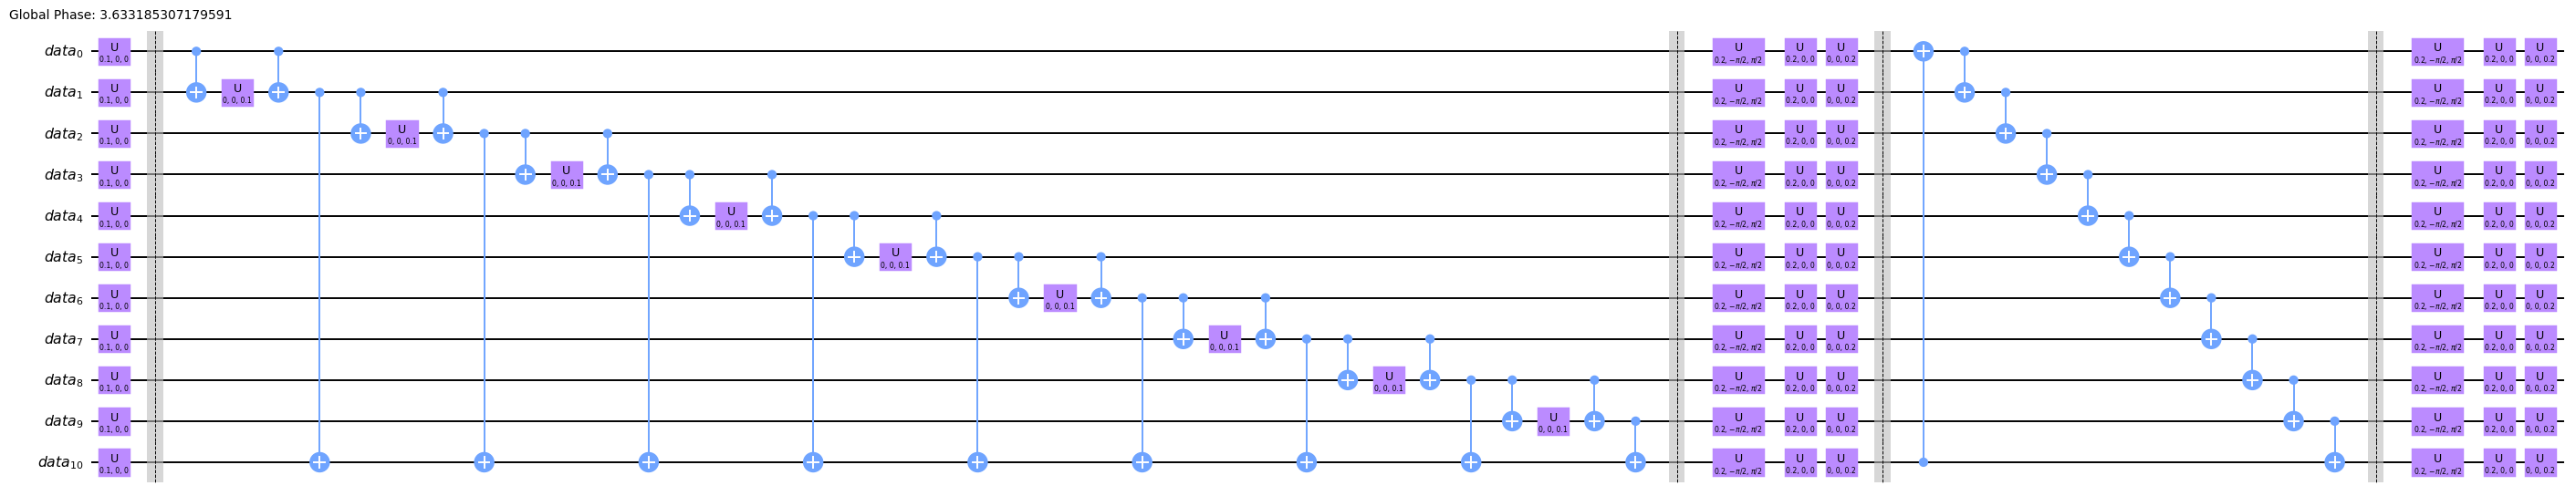

In [64]:
# After binding
num_qubits = 11
qc, input_params, weight_params = build_model(num_qubits, add_meas=False)
bind_dict = {**{p: 0.1 for p in input_params}, **{p: 0.2 for p in weight_params}}
qc_bound = qc.assign_parameters(bind_dict, inplace=False)

# Expand FM and ANS boxes
qc_full = qc_bound.decompose(reps=10)   # increase reps if still boxed

qc_full.draw(output="mpl", style="clifford", fold=120, scale=0.7)
